In [123]:
import numpy as np
import pandas as pd
import os
from pyspatialml import Raster
#from osgeo import gdal
import rasterio
from rasterio.merge import merge

import matplotlib as mpl 
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import ConfusionMatrixDisplay

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [124]:
os.chdir(r'C:\Users\hdey\Downloads\HimFac\PCA_USGAC')

## Loading Predictors 

In [125]:
predictors = ["Elevation.tif", "Slope.tif", "Soil_Moisture.tif", "Precip91.tif", "DisRiv.tif","NDVI.tif", "DD.tif", "TWI_Fil2.tif", "PopDen.tif", 
                "BuildingHeight.tif", "Dis_Road.tif", "POV.tif", "NoHSD.tif", "Minority.tif", "Age65.tif", "Age5.tif" ]

In [126]:
stack = Raster(predictors)
print(stack.names)
print(stack.shape)

dict_keys(['Elevation', 'Slope', 'Soil_Moisture', 'Precip91', 'DisRiv', 'NDVI', 'DD', 'TWI_Fil2', 'PopDen', 'BuildingHeight', 'Dis_Road', 'POV', 'NoHSD', 'Minority', 'Age65', 'Age5'])
(8806, 12979)


C:\Users\hdey\AppData\Roaming\Python\Python311\site-packages\matplotlib\colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
C:\Users\hdey\AppData\Roaming\Python\Python311\site-packages\matplotlib\colors.py:2295: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)


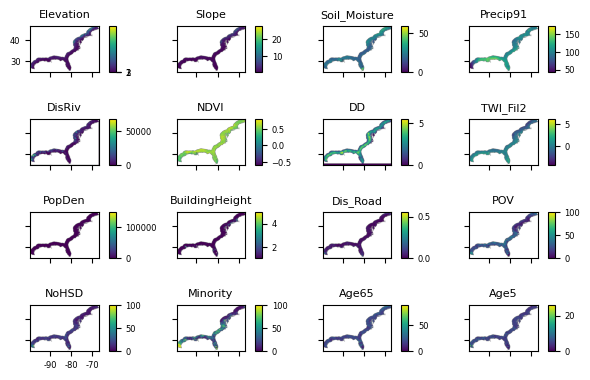

In [106]:
axs = stack.plot(figsize=(6, 4))
ax = axs.flatten()[0]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[0]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

## Load Samples

In [127]:
raw_data = pd.read_csv('Destroyed_FL_dmg19k.csv')
data = raw_data.drop(columns=['geometry'])
data.head(5)

,class,Elevation,Slope,Soil_Moisture,Precip91,DisRiv,NDVI,TWI_Fil2,DD,PopDen,BuildingHeight,Dis_Road,POV,Minority,NoHSD,Age65,Age5
0,0,0,0.002225,0,134.295761,0.000000,-0.506900,3.695495,4.989536,0.0,5,0.000828,0.0,0.0,0.0,0.0,0
1,0,11,0.364776,24,132.059341,3142.822510,0.610449,3.067967,1.333287,0.0,2,0.001995,0.0,0.0,0.0,0.0,0
2,0,9,0.209056,22,122.790253,1994.257080,0.256436,3.748312,3.243583,0.0,3,0.002197,0.0,0.0,0.0,0.0,0
3,0,18,0.287196,19,107.747169,546.414978,0.662350,-0.854100,3.450593,0.0,1,0.003044,0.0,0.0,0.0,0.0,0
4,0,7,0.103189,14,99.007423,705.165649,-0.002193,0.327504,2.792220,0.0,3,0.003191,0.0,0.0,0.0,0.0,0


## Pre-processing ( Scaling)

In [128]:
columns_to_scale = data.columns[1:]
data_to_scale = data[columns_to_scale]
X_S = data.iloc[:, 1:17]
y_S = data['class']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_S) 
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

scaled_z_df = pd.concat([scaled_df, y_S], axis=1) 

#print("Original Data:")
print(scaled_z_df.head())


   Elevation     Slope  Soil_Moisture  Precip91    DisRiv      NDVI  TWI_Fil2  \
0  -0.614941 -0.497186      -3.092905  1.352370 -0.706590 -5.034825  1.234160   
1  -0.510230 -0.298609       0.281511  1.220012 -0.259321  0.568944  0.996824   
2  -0.529268 -0.383900       0.000309  0.671441 -0.422779 -1.206514  1.254136   
3  -0.443596 -0.341101      -0.421493 -0.218853 -0.628828  0.829240 -0.486533   
4  -0.548307 -0.441886      -1.124496 -0.736097 -0.606235 -2.503599 -0.039641   

         DD   PopDen  BuildingHeight  Dis_Road       POV  Minority     NoHSD  \
0  1.970935 -0.44143        3.943872 -0.799150 -1.632688 -1.316289 -1.320003   
1 -1.583997 -0.44143        0.563357 -0.766503 -1.632688 -1.316289 -1.320003   
2  0.273363 -0.44143        1.690196 -0.760838 -1.632688 -1.316289 -1.320003   
3  0.474637 -0.44143       -0.563481 -0.737143 -1.632688 -1.316289 -1.320003   
4 -0.165492 -0.44143        1.690196 -0.733045 -1.632688 -1.316289 -1.320003   

      Age65      Age5  class  
0

In [52]:
#final_df.to_csv('final_df_scaled.csv', index= False)

## Multicolonearity analysis

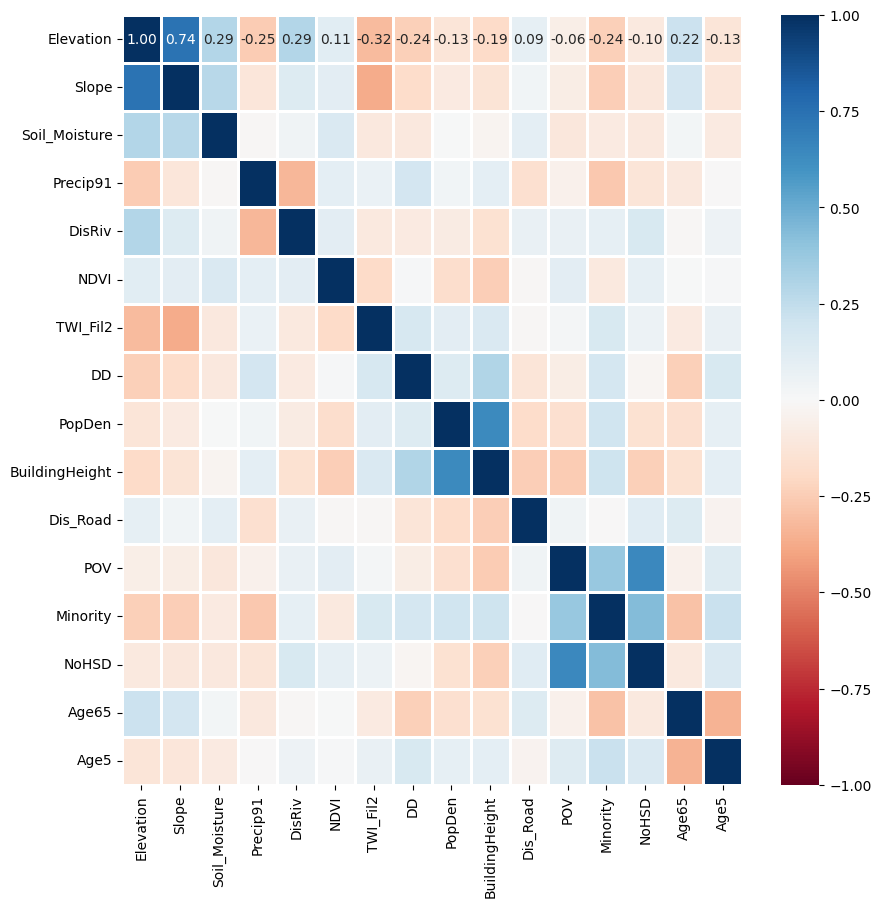

In [129]:
features = scaled_z_df.drop(columns=['class'])

column_names = features.columns
corrMatrix = features.corr()

# visualizing plot using seaborn
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True, linewidths=1, ax=ax, cmap='RdBu',  vmin=-1, vmax=1, fmt='.2f')

plt.show()

# note, if any of your feature shows correlation higher then say 0.80, remove that in drop columns, and reperform correlation

## Training and Testing dataset splitting

In [130]:
X = data.iloc[:, 1:17].to_numpy()
y = data['class'].to_numpy()

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [132]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (25447, 16)
y_train shape (25447,)
X_test shape (10907, 16)
y_test shape (10907,)


In [133]:
X_train

array([[7.00000000e+00, 3.97692580e-02, 2.10000000e+01, ...,
        1.95000000e+01, 8.40000000e+00, 1.20000000e+01],
       [1.48000000e+02, 1.55808496e+00, 3.00000000e+01, ...,
        4.20000000e+00, 7.00000000e+00, 8.00000000e+00],
       [4.50000000e+01, 7.60765851e-01, 1.80000000e+01, ...,
        2.08000000e+01, 2.14000000e+01, 5.00000000e+00],
       ...,
       [7.60000000e+01, 6.31607652e-01, 1.80000000e+01, ...,
        1.39000000e+01, 2.29000000e+01, 4.00000000e+00],
       [6.30000000e+01, 1.36113381e+00, 2.30000000e+01, ...,
        2.00000000e+00, 4.52000000e+01, 0.00000000e+00],
       [3.30000000e+01, 3.97284985e-01, 1.90000000e+01, ...,
        2.71000000e+01, 2.00000000e+01, 5.00000000e+00]])

In [134]:
X2 = data.iloc[:, 1:17]

In [135]:
X_scale = scaled_z_df.iloc[:, 1:17].to_numpy()
y_scale = scaled_z_df['class'].to_numpy()

In [136]:
X_trainZ, X_testZ, y_trainZ, y_testZ = train_test_split(X_scale, y_scale, test_size=0.3, random_state=42)

In [137]:
print('X_train shape', X_trainZ.shape)
print('y_train shape', y_trainZ.shape)
print('X_test shape', X_testZ.shape)
print('y_test shape', y_testZ.shape)

X_train shape (25447, 16)
y_train shape (25447,)
X_test shape (10907, 16)
y_test shape (10907,)


# ML Models

## Random Forest (RF) model

In [138]:
rf = RandomForestClassifier(max_depth=15, n_estimators=500, min_samples_split = 5, random_state=42)

In [119]:
# 4. Set up GridSearch parameters
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [ ]:
# 5. Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='roc_auc',
                           verbose=2)

In [139]:
# 6. Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=500,
                       random_state=42)

In [ ]:
# 7. Evaluate
best_model = grid_search.best_estimator_

In [ ]:
best_model

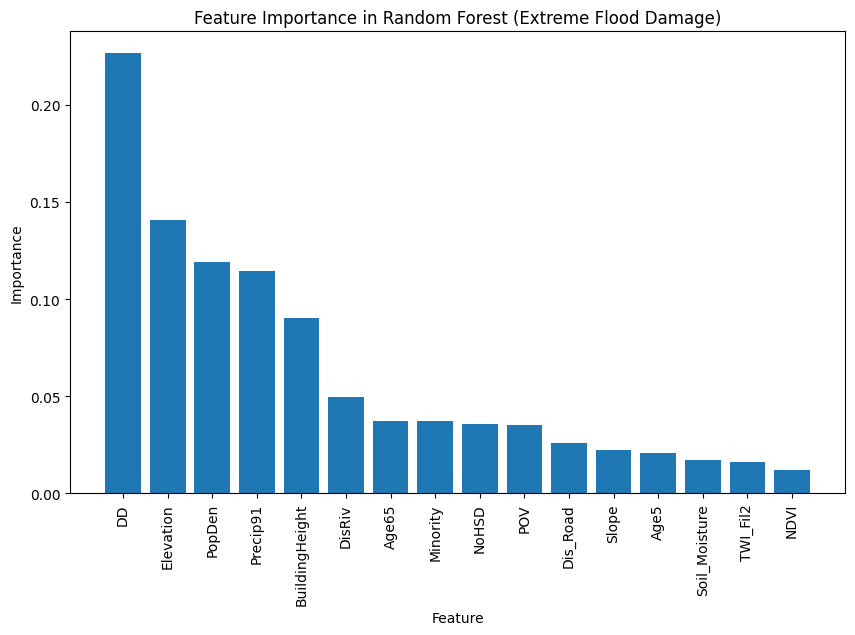

In [121]:
# Get feature importances
importances = rf.feature_importances_

# Get the indices of features sorted by importance
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest (Extreme Flood Damage)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")

# If X_train is a DataFrame
plt.xticks(range(X2.shape[1]), X2.columns[indices], rotation=90)

# If X_train is a NumPy array
#plt.xticks(range(X_train.shape[1]), indices, rotation=90)

plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

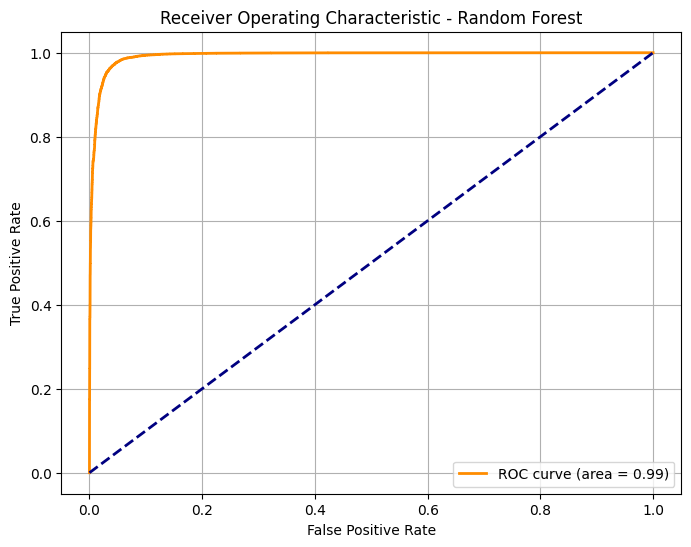

In [92]:
# Get predicted probabilities for the positive class
y_scores = rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [28]:
y_pred_rf = rf.predict_proba(X_test)

In [29]:
print("Sample predicted probabilities:", y_pred_rf[:10])

Sample predicted probabilities: [[1.84861288e-02 9.81513871e-01]
 [8.61540016e-01 1.38459984e-01]
 [3.24383010e-02 9.67561699e-01]
 [9.14333903e-01 8.56660974e-02]
 [3.84866673e-01 6.15133327e-01]
 [5.51325325e-03 9.94486747e-01]
 [9.99977071e-01 2.29285386e-05]
 [2.38770968e-02 9.76122903e-01]
 [3.44389371e-02 9.65561063e-01]
 [9.99973741e-01 2.62590164e-05]]


#### Contributing factors

In [122]:
for name, score in zip(X2.columns[0:], rf.feature_importances_):
    print(name, score)

Elevation 0.14053059575288343
Slope 0.02229797977357453
Soil_Moisture 0.0169535720921284
Precip91 0.1145232288814379
DisRiv 0.04974603672792571
NDVI 0.011918699094992932
TWI_Fil2 0.016065758841318695
DD 0.22646527267258687
PopDen 0.11923227203048255
BuildingHeight 0.0902072884138781
Dis_Road 0.025897346628956756
POV 0.0353648745784957
Minority 0.0370193711008519
NoHSD 0.035622808169448406
Age65 0.0374202791402423
Age5 0.020734616100795737


### Simulation

In [93]:
result_rfmodel = stack.predict_proba(rf)

C:\Users\hdey\AppData\Roaming\Python\Python311\site-packages\matplotlib\colors.py:2295: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)


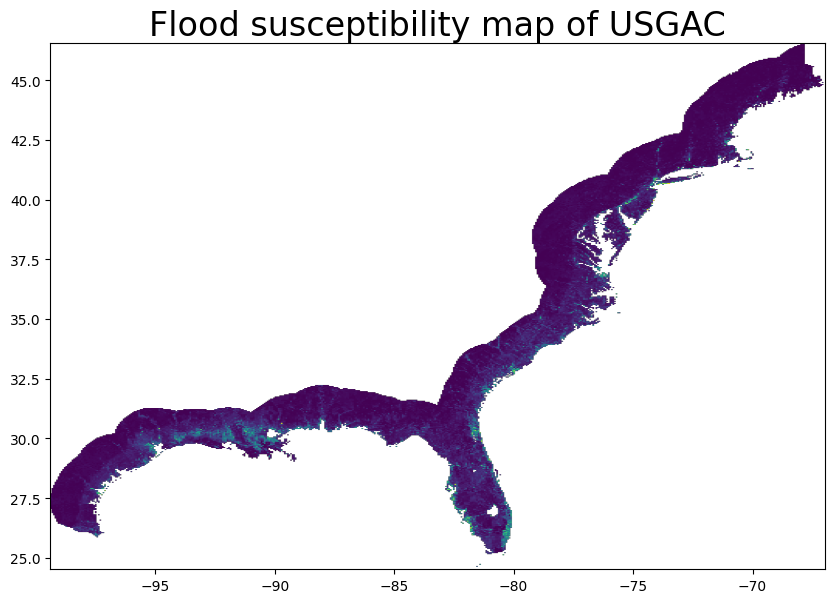

In [94]:
result_rfmodel.prob_1.plot(figsize=(10, 8))
plt.title('Flood susceptibility map of USGAC', size = 24)
plt.show()

In [95]:
result_rfmodel.prob_1.write(r"FRM_RF_USGAC_General_TWI.tif")

# Support Vector Machine (SVM) Model

In [140]:
# 3. Standardize the data (important for MLP!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [141]:
svm = SVC(C=1, kernel='rbf', probability=True, gamma='scale')

In [ ]:
# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 0.01, 0.1]
}

In [ ]:
# Setup GridSearchCV
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, 
                           scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

In [142]:
# Fit model
svm.fit(X_train_scaled, y_train)

SVC(C=1, probability=True)

In [ ]:
# Best parameters
print("Best Parameters:", grid_search_svm.best_params_)

# Evaluate on test data
best_model_svm = grid_search.best_estimator_

In [26]:
y_pred_svm = svm.predict_proba(X_test_scaled)[:, 1]

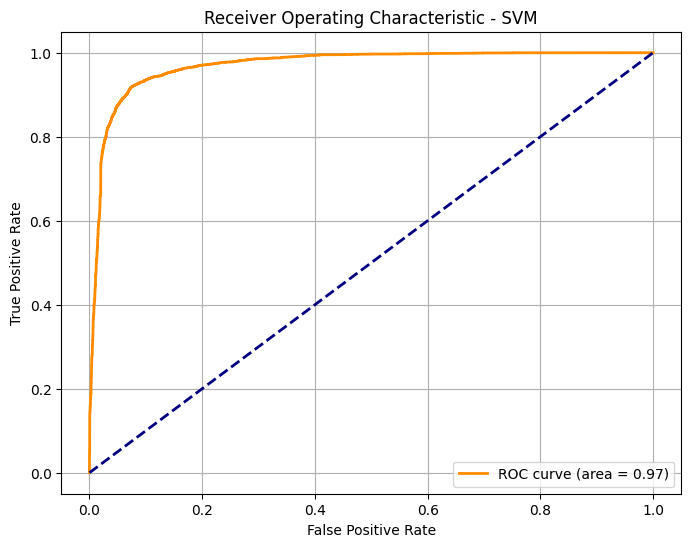

In [27]:
# Get predicted probabilities for the positive class
#y_scores = rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm)
roc_auc = auc(fpr, tpr)

# Plot ROC AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
result_SVMmodel = stack.predict_proba(svm)

In [ ]:
result_SVMmodel.prob_1.plot(figsize=(10, 8))
plt.title('MLP Flood RISK map of Tampa Bay', size = 24)
plt.show()

## Neural Network (MLP)

In [143]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

In [144]:


# 4. Define baseline MLP model
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    activation='relu',
                    solver='adam',
                    max_iter=500,
                    random_state=42)

In [145]:
# 5. Train the model
mlp.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

In [34]:
# 6. Evaluate
y_pred = mlp.predict(X_test_scaled)
y_prob = mlp.predict_proba(X_test_scaled)[:, 1]


In [35]:
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

ROC AUC Score: 0.9858964195061665


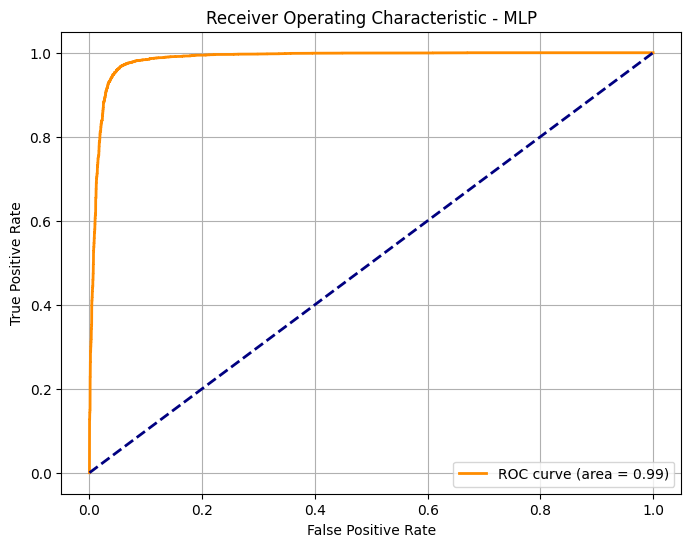

In [36]:
# Get predicted probabilities for the positive class
#y_scoresmlp = MLP_model_after_CV.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - MLP')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# ROC AUC

In [146]:
pred_prob_rf = rf.predict_proba(X_test)[:,1]
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob_rf, pos_label=1)
roc_auc1 = auc(fpr1, tpr1)

pred_prob_svm = svm.predict_proba(X_test_scaled)[:, 1]
fpr2, tpr2, threshold2 = roc_curve(y_test, pred_prob_svm, pos_label=1)
roc_auc2 = auc(fpr2, tpr2)

pred_prob_mlp = mlp.predict_proba(X_test_scaled)[:,1]
fpr3, tpr3, threshold3 = roc_curve(y_test, pred_prob_mlp, pos_label=1)
roc_auc3 = auc(fpr3, tpr3)

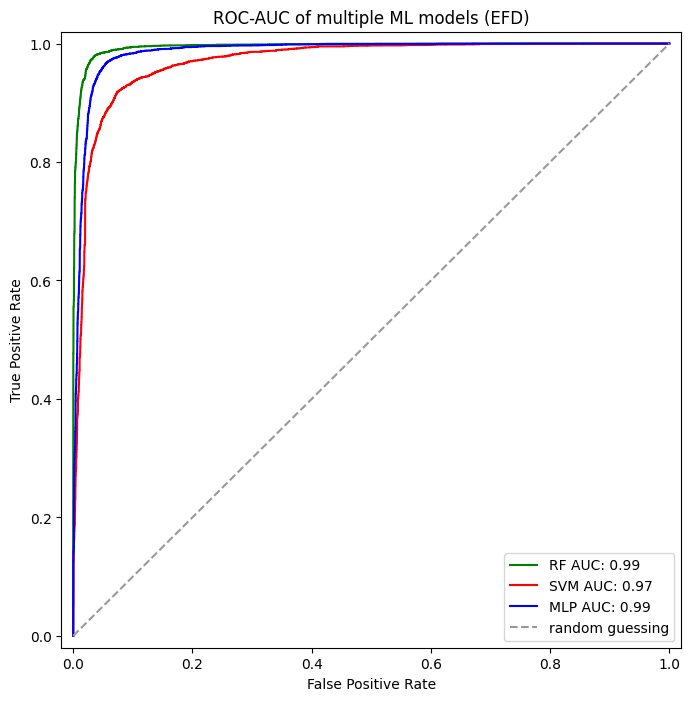

In [147]:
f, ax = plt.subplots(figsize=(8,8))
plt.plot(fpr1,tpr1, color ='Green', lw=1.5, label='RF AUC: {:.2f}'.format(roc_auc1))
plt.plot(fpr2,tpr2, color ='Red', lw=1.5, label='SVM AUC: {:.2f}'.format(roc_auc2))
plt.plot(fpr3,tpr3, color ='Blue', lw=1.5, label='MLP AUC: {:.2f}'.format(roc_auc3))
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6),
         label = 'random guessing')
plt.xlim([-.02, 1.02])
plt.ylim([-.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC of multiple ML models (EFD)')
plt.legend(loc="lower right")
plt.show()


## Evaluation metrics

In [148]:
# For Random Forest
pred_rf = rf.predict(X_test)

# For SVM
pred_svm = svm.predict(X_test_scaled)

# For MLP
pred_mlp = mlp.predict(X_test_scaled)


In [149]:
performance_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa Score', 'Jaccard Score'],
    'Random Forest' : [
        accuracy_score(y_test, pred_rf),
        precision_score(y_test, pred_rf),
        recall_score(y_test, pred_rf),
        f1_score(y_test, pred_rf),
        cohen_kappa_score(y_test, pred_rf),
        jaccard_score(y_test, pred_rf),
    ],
    'SVM': [
        accuracy_score(y_test, pred_svm),
        precision_score(y_test, pred_svm),
        recall_score(y_test, pred_svm),
        f1_score(y_test, pred_svm),
        cohen_kappa_score(y_test, pred_svm),
        jaccard_score(y_test, pred_svm),
    ],
    'MLP': [
       accuracy_score(y_test, pred_mlp), 
       precision_score(y_test, pred_mlp), 
       recall_score(y_test, pred_mlp), 
       f1_score(y_test, pred_mlp),
       cohen_kappa_score(y_test, pred_mlp),
        jaccard_score(y_test, pred_mlp),
    ]
}


df_perform = pd.DataFrame(performance_data)
df_perform.head(6)

,Metric,Random Forest,SVM,MLP
0,Accuracy,0.971486,0.917759,0.954525
1,Precision,0.968381,0.900963,0.946089
2,Recall,0.972270,0.930771,0.959839
3,F1 Score,0.970322,0.915624,0.952914
4,Kappa Score,0.942885,0.835455,0.908947
5,Jaccard Score,0.942354,0.844379,0.910063


In [150]:
df_perform.to_csv('Final_accuracy_ML_Des19k_Final.csv')

In [ ]:
df_melt = df_perform.melt(id_vars='Metric', var_name='Model', value_name='Score')

# Set the style and color palette
sns.set_style("whitegrid")
sns.set_palette("muted")

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt, x='Model', y='Score', hue='Metric')
plt.ylim(0.7, 1.0)
# Add chart details
plt.title('Comparison of Performance Metrics for Various Models', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(title='Model', title_fontsize=12, fontsize=10)
plt.show()

## SHAP analysis

In [ ]:
import shap
shap.initjs()
